In [1]:
import numpy as np
from skimage import io
from utils import grainPreprocess, grainMark, SEMDataset, grainDraw, Crack
from numpy.lib.stride_tricks import sliding_window_view

from matplotlib import pyplot as plt

from skimage import io, color, filters, morphology, util
from skimage.measure import EllipseModel
from skimage.color import rgb2gray
from skimage import filters, util
from skimage.morphology import disk, skeletonize, ball
from skimage.measure import approximate_polygon
from skimage import transform
import copy
from PIL import Image, ImageDraw, ImageFilter, ImageOps

from matplotlib import cm
import networkx as nx
from tqdm.notebook import tqdm

from bresenham import bresenham
from matplotlib import cm, colors
import pandas as pd

from shapely.geometry import Polygon, LineString
import rasterio.features
import matplotlib.pyplot as plt

from networkx.drawing import draw_networkx
import itertools

from multiprocessing import Lock, Process, Queue, current_process
import multiprocessing
import pickle

import cv2
from mpire import WorkerPool
import time
import shutil
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pathlib import Path
import json

import psutil
import math
import os
import subprocess

In [2]:
def graph_plot(g, img_contours,border = 30, save=False):

    img_tmp = img_contours.convert('RGB')
    img_tmp = 255 - np.array(img_tmp)
    dark_pixels = img_tmp[:,:,0]==0
    img_tmp[dark_pixels]=[255,0,0]
    
    pos = nx.get_node_attributes(g, 'pos')
    fig,axes = plt.subplots(1,1,figsize=(50,50))
    
    nx.draw(g, pos, ax =axes,  with_labels=True, node_color='lightblue', node_size=500, font_size=15)
    axes.imshow(img_tmp, cmap='gray')
    
    # axes[0].invert_yaxis()
    # axes[1].invert_yaxis()
    
    plt.axis("on")
    axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
    plt.xticks(np.arange(0,img_aligned.shape[1],100), fontsize=15)
    plt.yticks(np.arange(0,img_aligned.shape[0],100),fontsize=15)
    
    axes.arrow(5, 0, 5, img_aligned.shape[0], width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))
    axes.text(-20, img_aligned.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=25)
    
    axes.text(img_aligned.shape[1]/2 - border, - 2*border,'entry nodes', color=(0, 0, 1),fontsize=25)
    axes.text(img_aligned.shape[1]/2 - border,img_aligned.shape[0]+ 2*border,'exit nodes', color=(1, 0, 0),fontsize=25)

    if save:
        plt.savefig('graph.jpg',bbox_inches='tight')
    plt.show()

/mnt/e/python/wc_cv/cv/utils.py:92: UserWarning: Possible precision loss converting image of type float64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  tmp_img = SEMDataset.preprocess_image(image, pad=True, border=border,disk=8)


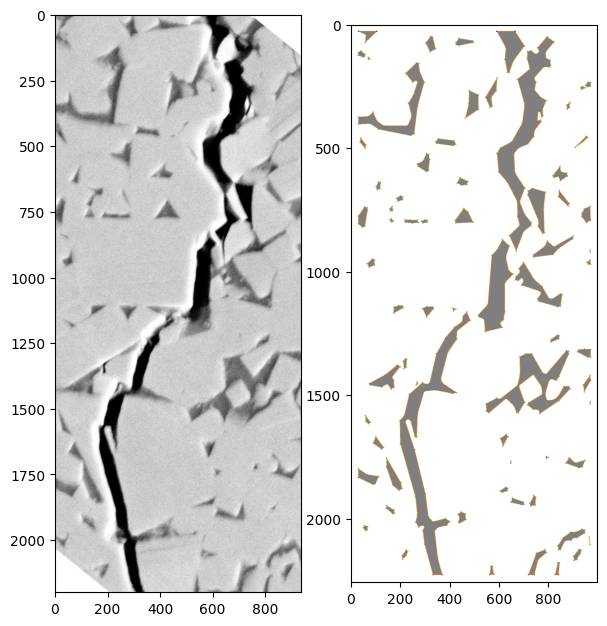

  0%|          | 0/531 [00:00<?, ?it/s]

In [3]:
eps = 300
image = io.imread('WC+8Co_5_crack.jpg')[200:-300]

entry_nodes, exit_nodes, num_of_nodes, img_aligned, img_drawings, nodes_index2global_nodes_coord, cnts, nodes_index2global_contour_index, nodes_index2local_contour_index = Crack.preprocess_graph_image(image)

plot=True

if plot:
    fig, axes = plt.subplots(1,2,figsize = (7,14))
    axes[0].imshow(image)
    axes[1].imshow(img_drawings)
    # plt.savefig('miniature_figures_aligned.png', bbox_inches='tight')
    plt.show()

g, img_contours= Crack.create_crack_graph(img_aligned.shape, num_of_nodes,nodes_index2global_nodes_coord,cnts,eps=eps)

# graph_plot(g, img_contours)

# nx.write_edgelist(g,'350x500.txt',data=False)

# save graph object to file
# pickle.dump(g, open('g.pickle', 'wb'))

# Graph info

In [ ]:
nx.path_weight(g,[20,21], 'weight')

In [ ]:
def find_paths(entry_node, exit_node):
    
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    all_wc_edges = []
    all_co_edges = []
    all_wc_co_edges = []
    all_wc_pixels = []
    all_co_pixels = []
    all_wc_co_pixels = []
    
    # paths = list(nx.all_simple_paths(g, source=entry_node, target=exit_node))
    # paths =  list(nx.all_shortest_paths(g, source=entry_node, target=exit_node))
    paths =  list(nx.all_shortest_paths(g, source=entry_node, target=exit_node, weight = 'weight'))

    for path in paths: 
        all_paths.append(path)
        all_entry_nodes.append(int(entry_node))
        all_exit_nodes.append(int(exit_node))
        all_path_len_edges.append(len(path))
        l=nx.path_weight(g,path, 'weight')
        all_path_len_pixels.append(l)
        
        points_stack = np.stack([path, np.roll(path,shift=-1,axis=0)],axis=1)

        types = []
        edges_lens=[]
        for points in points_stack:
            node1,node2 = points
            edges_lens.append(nx.path_weight(g,[node1,node2], 'weight'))
            cnt_index_1 = nodes_index2global_contour_index[node1]
            cnt_index_2 = nodes_index2global_contour_index[node2]
            
            # different contours, WC
            if cnt_index_1!=cnt_index_2:
                types.append(0)
                
            # same contour, WC-Co 
            elif abs(cnt_index_1-cnt_index_2)<2:
                types.append(1)
                
            else:
                x1,y1 = nodes_index2global_nodes_coord[node1]
                x2,y2 = nodes_index2global_nodes_coord[node2]
                v1 = np.array([x2-x1,y2-y1])
                
                cnt = cnts[cnt_index_1]
                cnt_point_1_index = nodes_index2local_contour_index[node1]
                node0=cnt[cnt_point_1_index-1]
                node3=cnt[cnt_point_1_index+1]
                
                x0,y0 = nodes_index2global_nodes_coord[node0]
                x3,y3 = nodes_index2global_nodes_coord[node3]
                v2 = np.array([x3-x0,y3-y0])

                inter_x,inter_y = np.intersect1d(v1,v2)
                
                #  in contour
                if (inter_x<x3 and inter_y<y3 and inter_x>x0 and inter_y>y0) or (inter_x>x3 and inter_y>y3 and inter_x<x0 and inter_y<y0):
                    types.append(2)
                else:
                    types.append(0)

        types = np.array(types)
        edges_lens = np.array(edges_lens)
        
        wc_edges_indices = np.where(types==0)[0]
        co_edges_indices = np.where(types==2)[0]
        wc_co_edges_indices = np.where(types==1)[0]

        wc_pixels_lens=edges_lens[wc_edges_indices]
        co_pixels_lens=edges_lens[co_edges_indices]
        wc_co_pixels_lens=edges_lens[wc_co_edges_indices]
        z = np.sum(edges_lens)
            
    
        all_wc_edges.append(len(wc_edges_indices)/len(path))
        all_co_edges.append(len(co_edges_indices)/len(path))
        all_wc_co_edges.append(len(wc_co_edges_indices)/len(path))
        
        all_wc_pixels.append(np.sum(wc_pixels_lens)/z)
        all_co_pixels.append(np.sum(co_pixels)/z)
        all_wc_co_pixels.append(np.sum(wc_co_pixels)/z)

    return pd.DataFrame({'path':all_paths,
                         'path_len_edges':all_path_len_edges,
                         'path_len_pixel':all_path_len_pixels,
                         'entry_node':all_entry_nodes,
                         'exit_node':all_exit_nodes,
                         'wc_edges': all_wc_edges, 
                         'co_edges': all_co_edges, 
                         'wc_co_edges': all_wc_co_edges, 
                         'wc_pixels': all_wc_edges, 
                         'co_pixels': all_co_pixels, 
                         'wc_co_pixels': all_wc_co_pixels, 
                        })

In [21]:
%%time

mem1 = psutil.virtual_memory().available

# workers = 23

def p(a,b):
    print(a+b)

entry_nodes = [ 4, 11, 17, 70, 75, 71]
exit_nodes = [ 319, 320,514, 529]
# cart_list=[entry_nodes, exit_nodes]
# cart_list=[element for element in itertools.product(*cart_list)]

# with WorkerPool(n_jobs=workers) as pool:
#     results = pool.map(find_paths, cart_list, progress_bar= True)

# df = pd.concat(results,axis=0)

mem2 = psutil.virtual_memory().available
# print('entry_nodes', entry_nodes)
# print('exit_nodes', exit_nodes)
print('used memory Gib',(mem1-mem2)/1024**3)

find_paths(4, 319)

used memory Gib 0.0


NetworkXNoPath: path does not exist

In [ ]:
# df[(df.entry_node==70)]

df['entry_node'].hist()

In [ ]:
# mean_path_length_edges = df['path_len_edges'].mean()

df=[]
mean_path_length_edges = 1

mean_degree  = np.array(g.degree)[:,1].mean()
entry_nodes_num = len(entry_nodes)
exit_nodes_num = len(exit_nodes)
number_of_nodes = len(g.nodes)

cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

print(f'number of paths {len(df)/1e6:.2}*10^6')
print('-----')
print(f'number of entry nodes n={entry_nodes_num}' )
print(f'number of exit nodes k={exit_nodes_num}')
print(f'mean node degree p={mean_degree:.2f}')
print(f'mean path length edges L={mean_path_length_edges:.2f}')
print(f'number of nodes t={number_of_nodes}')
print(f'number of edges t={len(g.edges)}')
print(f'number  of pairs={len(cart_list)}')

m = (number_of_nodes-entry_nodes_num-exit_nodes_num)/mean_path_length_edges
print(f'm={m:.2f}')

N = entry_nodes_num*exit_nodes_num*(mean_degree/2 * mean_degree/2)**m
print(f'N={N/1e6:.2f}*10^6')

# Shortest paths

In [ ]:
# 'path':all_paths,
# 'path_len_edges':all_path_len_edges,
# 'path_len_pixel':all_path_len_pixels,
# 'entry_node':all_entry_nodes,
# 'exit_node':all_exit_nodes

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

N=1

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    # for i in range(N):
    row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_entry_paths.append(row)

shortest_exit_paths = []
for exit_node in tqdm(exit_nodes):
    # for i in range(N):
    row = df[df.exit_node==exit_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_exit_paths.append(row)

df_shortest_entry = pd.DataFrame(shortest_entry_paths)
df_shortest_exit = pd.DataFrame(shortest_exit_paths)

In [ ]:
df.__len__()

In [ ]:
# df['path'] = df['path'].apply(lambda x: np.array(x))
# df.to_csv('shortest_paths_edges.csv')

df1=pd.read_csv('shortest_paths_edges.csv')

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

N=10

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    for i in range(N):
        row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[i]
        shortest_entry_paths.append(row)


df1_shortest_entry = pd.DataFrame(shortest_entry_paths)


In [ ]:
df_shortest_entry

In [ ]:
df_shortest_entry

In [ ]:
fig, axes = plt.subplots(1,1,figsize=(15,20))
border=30

pos = nx.get_node_attributes(g, 'pos')

df_shortest_entry = copy.copy(df)

cmap = cm.get_cmap("Spectral")
# need to normalize because color maps are defined in [0, 1]
norm = colors.Normalize(df_shortest_entry['path_len_pixel'].values.min(), df_shortest_entry['path_len_pixel'].values.max())


for i in range(len(df_shortest_entry)):
    line = df_shortest_entry.iloc[i]
    path = line['path']
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color=cmap(norm(line['path_len_pixel'])),width=2)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['entry_node']],node_color='blue',node_size = 100)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['exit_node']],node_color='red',node_size = 100)


im = axes.imshow(img_aligned, cmap='gray')

plt.axis("on")
axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes.arrow(12, border-5, 0, 200, width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))

axes.text(2, img_aligned.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=15)
axes.text(img_aligned.shape[1]/2-25, border/3,'entry nodes', color=(0, 0, 1),fontsize=15)
axes.text(img_aligned.shape[1]/2-25,img_aligned.shape[0] - border/3,'exit nodes', color=(1, 0, 0),fontsize=15)


fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axes)

# plt.savefig('shortests_paths.jpg',bbox_inches='tight')

plt.show()

In [ ]:
df=pd.read_csv('paths.csv')

entry_nodes = np.unique(df['entry_node'])
exit_nodes = np.unique(df['exit_node'])

shortest_entry_paths = []
for entry_node in tqdm(entry_nodes):
    row = df[df.entry_node==entry_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_entry_paths.append(row)

shortest_exit_paths = []
for exit_node in tqdm(exit_nodes):
    row = df[df.exit_node==exit_node].sort_values(by='path_len_pixel').iloc[0]
    shortest_exit_paths.append(row)

df_shortest_entry = pd.DataFrame(shortest_entry_paths)
df_shortest_exit = pd.DataFrame(shortest_exit_paths)



fig,axes = plt.subplots(1,1,figsize=(15,15))

pos = nx.get_node_attributes(g, 'pos')

for i in range(len(df_shortest_entry)):
    line = df_shortest_entry.iloc[i]
    path = line['path']
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color='blue',width=1)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['entry_node']],node_color='blue',node_size = 100)

for i in range(len(df_shortest_exit)):
    line = df_shortest_exit.iloc[i]
    path = list(reversed(line['path']))
    path_edges = list(zip(path,path[1:]))

    nx.draw_networkx_edges(g,pos,edgelist=path_edges,edge_color='r',width=1)
    nx.draw_networkx_nodes(g,pos,nodelist=[line['exit_node']],node_color='r',node_size = 100)

axes.imshow(img_aligned, cmap='gray')

plt.axis("on")
axes.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

axes.arrow(12, border-5, 0, 200, width=0.3, length_includes_head=True, head_width=10, head_length=10,color=(0,0,0))

axes.text(2, img_aligned.shape[0]*2/3,'hit direction',rotation=90, color=(0, 0, 0),fontsize=15)
axes.text(img_aligned.shape[1]/2-25, border/3,'entry nodes', color=(0, 0, 1),fontsize=15)
axes.text(img_aligned.shape[1]/2-25,img_aligned.shape[0] - border/3,'exit nodes', color=(1, 0, 0),fontsize=15)

# plt.savefig('shortests_paths.jpg',bbox_inches='tight')

plt.show()

# Deprecated

# Algorithm debugging

In [ ]:
eps=100
line_eps = 2
border_eps = 0
border_number_min = 1
border_pixel=255

test_show_eps=10

start_node_index = 20
node_index = 21

start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
end_node_x, end_node_y = nodes_index2global_nodes_coord[node_index]
print(start_node_x,start_node_y)
print(end_node_x, end_node_y)


ab = LineString([(start_node_x, start_node_y), (end_node_x, end_node_y)])
left = ab.parallel_offset(line_eps, 'left')
left_p,_ = np.array(left.coords)
perp_v = np.array((start_node_x-left_p[0],start_node_y-left_p[1]))
perp_v = perp_v/np.linalg.norm(perp_v)

mean_border_pixels=0

test_map=np.zeros_like(img_contours_np)

n=[]
for p in range(0 - line_eps, 1 + line_eps):
    line_coords=np.array(list(bresenham(np.round(start_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(start_node_y+p*perp_v[1]).astype(np.int32),
                                        np.round(end_node_x+p*perp_v[0]).astype(np.int32),
                                        np.round(end_node_y+p*perp_v[1]).astype(np.int32)
                                       )))
    
    line_coords_pixels=img_contours_np[line_coords[:,0],line_coords[:,1]][2:-2]
    border_pixels_num = np.where(line_coords_pixels==border_pixel)[0].shape[0]

    n.append(line_coords_pixels)
        
    print(border_pixels_num)
    if border_pixels_num<=border_eps:
        mean_border_pixels+=1

    test_map[line_coords[:,0],line_coords[:,1]]=170

test_map[start_node_x,start_node_y]=255
test_map[end_node_x,end_node_y]=255

plt.figure(figsize=(10,10))
plt.imshow(test_map[start_node_x-test_show_eps:end_node_x+test_show_eps,start_node_y-test_show_eps:end_node_y+test_show_eps])

print('result', mean_border_pixels)
if mean_border_pixels>=border_number_min and start_node_index!=node_index:
    print('added')


In [ ]:
%%time

mem1 = psutil.virtual_memory().available
def find_paths(entry_node, exit_node):
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    os.system(f'/bin/bash -c "bfs_custom/bfs_paths_dev bfs_custom/200x500.txt {entry_node} {exit_node} ./tmp/" ')
    
    paths = 0
    return 

workers = 200
cart_list=[entry_nodes, exit_nodes]
cart_list=[element for element in itertools.product(*cart_list)]

with WorkerPool(n_jobs=workers) as pool:
    results = pool.map(find_paths, cart_list, progress_bar= True)

# df = pd.concat(results,axis=0)

mem2 = psutil.virtual_memory().available
print('entry_nodes', entry_nodes)
print('exit_nodes', exit_nodes)
print('used memory Gib',(mem1-mem2)/1024**3)

In [ ]:
# image = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-001.jpeg')[:520,:500]
# image = io.imread('WC+8Co_5_fixed_001.jpg')[:300,:800]
image = io.imread('../datasets/original/o_bc_left/Ultra_Co6_2/Ultra_Co6_2-003.jpeg')[:300,:500]

#  некорректно
# image = io.imread('../datasets/original/o_bc_left/Ultra_Co25/Ultra_Co25-001.jpeg')[:200,:200]


entry_nodes, exit_nodes, num_of_nodes, img_aligned, nodes_index2global_nodes_coord, cnts = preprocess_graph_image(image,plot=True)

g = create_crack_graph(img_aligned.shape, num_of_nodes,nodes_index2global_nodes_coord,cnts,  plot=False)

# nx.write_edgelist(g,'350x500.txt',data=False)

# save graph object to file
# pickle.dump(g, open('g.pickle', 'wb'))


#200

# entry_nodes [18, 30, 11, 17, 0, 10]
# exit_nodes [83, 45, 46, 47, 57, 58, 59]

# 250

# entry_nodes [18, 30, 11, 17, 0, 10]
# exit_nodes [81, 82, 83, 78, 79, 74, 75]

# 300

# entry_nodes [17, 28, 11, 16, 0, 10]
# exit_nodes [96, 97, 84, 85, 76, 77]

# 350 

# entry_nodes [17, 28, 11, 16, 0, 10]
# exit_nodes [111, 112, 101, 102, 84, 85]

# plt.imshow(img_aligned)

In [ ]:
!cat /proc/meminfo | grep Mem

In [ ]:
!nvcc -O2 bfs_custom/bfs_paths_dev.cu -o bfs_custom/bfs_paths_dev 
!nvcc -O2 bfs_custom/bfs_paths.cu -o bfs_custom/bfs_paths

In [ ]:
!bfs_custom/bfs_paths bfs_custom/300x500.txt 0 97 ./tmp/

In [ ]:
with open('bfs_paths_15_110_300x500.json') as f:
    data = json.load(f)

In [ ]:
data.__len__()

In [ ]:
!cat /proc/meminfo | grep Mem

In [ ]:
# df[(df.entry_node==0) & (df.exit_node==75) ]

image.shape

In [ ]:
# save = True
save = False

# graph_plot(g, img_contours,save=save)

In [ ]:
%%time

def find_paths(entry_node, exit_node):
    all_paths=[]
    all_entry_nodes=[]
    all_exit_nodes=[]
    all_path_len_edges=[]
    all_path_len_pixels=[]
    
    paths = list(nx.all_simple_paths(g, source=entry_node, target=exit_node,cutoff=10))

    for path in paths: 
        all_paths.append(path)
        all_entry_nodes.append(int(entry_node))
        all_exit_nodes.append(int(exit_node))
        all_path_len_edges.append(len(path))
        l=nx.path_weight(g,path, 'weight')
        all_path_len_pixels.append(l)

    return pd.DataFrame({'path':all_paths,
                         'path_len_edges':all_path_len_edges,
                         'path_len_pixel':all_path_len_pixels,
                         'entry_node':all_entry_nodes,
                         'exit_node':all_exit_nodes
                        })


paths_num = []
mean_paths_len = []
std_paths_len = [] 

closest_nodes = []

epsilon = 100
workers = 23

pos = nx.get_node_attributes(g, 'pos')

all_paths = []
cart_list = []

for node1,data1 in tqdm(g.nodes(data=True)):
    target_pos = data1['pos']
    closest_nodes.append([])
    for node2, data2 in g.nodes(data=True):
        node_pos = data2['pos']
        distance = math.sqrt((node_pos[0] - target_pos[0])**2 + (node_pos[1] - target_pos[1])**2)
        if distance <= epsilon:
            closest_nodes[node1].append((node2, distance))
            exit_nodes = np.array(closest_nodes[node1])[1:,0]
            tmp_cart_list =[[node1], list(exit_nodes)]
            tmp_cart_list=[element for element in itertools.product(*tmp_cart_list)]
            cart_list.extend(tmp_cart_list)


cart_list_unique = np.unique(cart_list,axis=0)
cart_list_unique =[list(element) for element in cart_list_unique]

with WorkerPool(n_jobs=workers) as pool:
    results = pool.map(find_paths, cart_list_unique, progress_bar = True)

all_paths.append(results)
    


# Shortest paths plot

In [ ]:
df_shortest_entry['path'] = df_shortest_entry['path'].apply(lambda x: np.array(x))
df_shortest_exit['path'] = df_shortest_exit['path'].apply(lambda x: np.array(x))

df_shortest_entry['path_len_pixel'] = df_shortest_entry['path_len_pixel'].apply(lambda x: int(x))
df_shortest_exit['path_len_pixel'] = df_shortest_exit['path_len_pixel'].apply(lambda x: int(x))

df_shortest_entry['entry_node'] = df_shortest_entry['entry_node'].apply(lambda x: int(x))
df_shortest_exit['entry_node'] = df_shortest_exit['entry_node'].apply(lambda x: int(x))

df_shortest_entry['exit_node'] = df_shortest_entry['exit_node'].apply(lambda x: int(x))
df_shortest_exit['exit_node'] = df_shortest_exit['exit_node'].apply(lambda x: int(x))

df_shortest_entry['path_len_edges'] = df_shortest_entry['path_len_edges'].apply(lambda x: int(x))
df_shortest_exit['path_len_edges'] = df_shortest_exit['path_len_edges'].apply(lambda x: int(x))

df_shortest_entry.to_csv('shortest_entry.csv')
df_shortest_exit.to_csv('shortest_exit.csv')

# Plot distances hists

In [ ]:
def plot_paths_dist(data, name, title=False, folder='tmp', save=True, bins = 60, xlim = None):
    std=np.std(data)
    mean=np.mean(data)
    
    plt.figure(figsize=(7,5))
    plt.hist(data, bins=bins)
    
    plt.axvline(mean-2*std,color=(0.2,0.5,0.5))
    plt.axvline(mean-std,color=(1,1,0))
    plt.axvline(mean,color=(1,0,0))
    plt.axvline(mean+std,color=(0,1,1))
    plt.axvline(mean+2*std,color=(0,1,0.5))
    if title:
        plt.title(title)
    plt.legend(['mean-2*std','mean-std','mean','mean+std','mean+2*std',f'paths len\nnumber of paths\n{len(data)/10**6:.3f}*10^6\nmean={mean:.2f}\nstd={std:.2f}'])
    plt.xlabel('length of crack, pixels')
    
    if xlim:
        plt.xlim(xlim[0],xlim[0])
    
    plt.savefig(f'{folder}/{name}', bbox_inches='tight')
    plt.show()


pixel = 50 / 1000

save=False
# save=True

folder = "tmp_plots"
Path(folder).mkdir(parents=True, exist_ok=True)

names = []

# all paths pixels 
data=df['path_len_pixel']
name = f"entry_exit_paths_all_pixels.jpg"
names.append(name)
plot_paths_dist(data, name, folder = folder, save=save)

# exit paths pixels 
for i,exit_node in tqdm(enumerate(exit_nodes)):
    name = f"entry_exit_paths_{i}_pixels.jpg"
    names.append(name)
    data=df[df['exit_node']==exit_nodes[i]]['path_len_pixel']
    plot_paths_dist(data, name,title=f'exit node {exit_node}', folder=folder, save=save)

# all paths edges 
data=df['path_len_edges']
name =  f"entry_exit_paths_all_edges.jpg"
names.append(name)
plot_paths_dist(data, name, folder=folder, save=save, bins=30)

# exit paths edges 
for i,exit_node in tqdm(enumerate(exit_nodes)):
    name = f"entry_exit_paths_{i}_edges.jpg"
    names.append(name)
    data=df[df['exit_node']==exit_nodes[i]]['path_len_edges']
    plot_paths_dist(data, name,title=f'exit node {exit_node}', folder = folder, save=save, bins=30)

shutil.make_archive('plots', 'zip', folder)

# Dynamic grid search (not done)

img_viztmp_img1) image_nodes_coord2nodes_index
2) nodes_index2global_nodes_coord
3) image_node_coord2node_index

1) grid_cell_coord2grid_cell_index
2) grid_cell_index2grid_cell_coord
3) image_coord2grid_cell_index

In [ ]:
# process nodes of graph
# add all nodes to graph
g = nx.DiGraph()
image_node_coord2node_index = np.zeros(img_shape)
for key in range(num_of_nodes):
    x,y=nodes_index2global_nodes_coord[key]
    image_node_coord2node_index[x,y]=key
    g.add_node(key, pos=(x,y))
    
# pos = nx.get_node_attributes(g, 'pos')
# plt.figure(figsize = (5,5))
# nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# create grid
cell_size=10
grid_size=np.int32(img_shape/cell_size)

number_of_cells=0
grid_cell_coord2grid_cell_index={}
grid_cell_index2grid_cell_coord={}
image_coord2grid_cell_index = np.zeros(img_shape)
for xi in range(grid_size[0]):
    for yi in range(grid_size[1]):   
        grid_cell_coord2grid_cell_index[(xi,yi)]=number_of_cells
        grid_cell_index2grid_cell_coord[number_of_cells]=(xi,yi)
        
        # map of grid cell indices
        image_coord2grid_cell_index[xi*cell_size:(xi+1)*cell_size,
                                 yi*cell_size:(yi+1)*cell_size
                                ]=np.full((cell_size,cell_size), number_of_cells)
        number_of_cells+=1

# plt.imshow(image_coord2grid_cell_index[:10,:100])    

grid = np.array(sliding_window_view(image_node_coord2node_index, (cell_size, cell_size))[::cell_size, ::cell_size])
grid_summed = grid.sum(axis=(2,3))
plt.imshow(grid_summed,cmap='gray', origin='lower')

In [ ]:
def check_borders(point, shape):
    if point[0]>=0 and point[1]>=0 and point[0]<=shape[0] and point[1]<=shape[1]:
        return True
    else:
        return False
K=10
img_viz_numpy=np.array(img_aligned)

#127, 255

m=[]
# grid search
for start_node_index in tqdm(range(num_of_nodes)):
    
    # choose cell
    start_node_x,start_node_y=nodes_index2global_nodes_coord[start_node_index]
    grid_cell_id=image_coord2grid_cell_index[start_node_x,start_node_y]
    cell_x,cell_y=grid_cell_index2grid_cell_coord[grid_cell_id]
    
    if cell_x-K//2<0:
        left_border_x=K//2-cell_x
    else:
        left_border_x=cell_x-K//2-2

    # right x slice border
    if cell_y+K//2>grid.shape[0]:
        right_border_x=grid.shape[0]
    else:
        right_border_x=cell_y+K//2+2

    # upper_border
    if cell_y+K>grid.shape[1]-1:
        upper_border=grid.shape[1]-1
    else:
        upper_border=cell_y+K

    grid_summed_slice=grid_summed[left_border_x:right_border_x,cell_y:upper_border]
    summed_grid_cell_x,summed_grid_cell_y=np.where(grid_summed_slice!=0)
    grid_slice=grid[summed_grid_cell_x,summed_grid_cell_y]

    nodes_indices_indices = np.where(grid_slice.flatten()!=0)
    nodes_indices =grid_slice.flatten()[nodes_indices_indices]

    for node_index in (nodes_indices):
        end_node_x,end_node_y=nodes_index2global_nodes_coord[node_index]
        mean_pixels=[]
        for p in range(-2,3):
            line_coords=np.array(list(bresenham(start_node_x+p, start_node_y,end_node_x+p, end_node_y)))
            mean_pixel=np.mean(img_viz_numpy[line_coords[:,0],line_coords[:,0]])
            m.append(mean_pixel)
            mean_pixels.append(mean_pixel)
        line_mean=np.mean(mean_pixels)
        if line_mean<160 or line_mean>222:
            g.add_edge(start_node_index,node_index)
        # m.append(np.mean(mean_pixels))
   

In [ ]:
plt.imshow(img_viz_numpy,cmap='gray', origin='lower')

In [ ]:
pos = nx.get_node_attributes(g, 'pos')
plt.figure(figsize = (5,5))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
plt.hist(m,bins=20)

In [ ]:
np.array(list(bresenham(-1, -4, 3, 2)))

In [ ]:
#     for xi in range(-K//2,K//2+1):
#         cell_x_tmp = cell_x + xi
#         for yi in range(0,K):
#             cell_y_tmp = cell_y + yi
            
#             if check_borders((cell_x_tmp,cell_y_tmp),img_shape):



    # wave_flag=True
    # wave=0
    # indices=[]

    # while wave_flag:
        # center cell
#         center_point=[node_x, node_y+1]
        
#         if check_borders(center_point):
#             indices.append(center_point)
        
#         # border cells
#         for i in range(wave+1):
#             left_point=[node_x-1-i, node_y-1-i]
#             right_point=[node_x+1+i, node_y+1+i]
            
#         if check_borders(left_point):
#             indices.append(left_point)
            
#         if check_borders(right_point):
#             indices.append(right_point)

Entry points 22
number of nodes 1770

In [ ]:
# contour_points = cnts[3]
gs=[]


for i,contour_points in enumerate(cnts):
    g = nx.Graph()

    for i, point in enumerate(contour_points):
        g.add_node(i, pos=point)


    for i in range(len(contour_points) - 1):
        g.add_edge(i, i + 1)

    g.add_edge(len(contour_points) - 1, 0)
    gs.append(g)

names = tuple([f"g{i}-" for i in range(len(cnts))])

g=nx.union_all(gs,rename=names)

pos = nx.get_node_attributes(g, 'pos')

plt.figure(figsize = (10,10))
nx.draw(g, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)
plt.show()

In [ ]:
G = nx.dorogovtsev_goltsev_mendes_graph(3)
nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

In [ ]:
# G = nx.path_graph(5)

# input 22 points
# output 66 points
# G = nx.complete_multipartite_graph(4,5)
G = nx.dorogovtsev_goltsev_mendes_graph(7)
# nx.draw(G, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

G.number_of_nodes()

In [ ]:
# white_img = np.zeros_like((orig_img_padded))
# white_img = np.ascontiguousarray(white_img, dtype=np.uint8)
# cnts_adj = [cnt.reshape((-1,1,2)) for cnt in cnts ]
# img_contours_np = cv2.drawContours(white_img,cnts_adj,-1,(255),2).astype(np.uint8)

# plt.figure(figsize=(15,5))
# plt.imshow(img_contours_np[:200,:500],cmap='gray')
# plt.show()


# ------------# 

# img_contours = draw_edges(np.zeros_like(orig_img_padded), cnts=cnts, r=2, l_width=1)
# img_contours_np = np.array(img_contours)

# plt.figure(figsize=(15,5))
# plt.imshow(img_contours_np[:200,:500],cmap='gray')
# plt.show()